**IMPORTING REQUIRED LIBRARIES**

In [1]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 18.5 MB/s eta 0:00:00:00:0100:01


In [3]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam,lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.nn.parallel import DataParallel
import torchvision.models as models
from PIL import Image
import numpy as np
from tqdm import tqdm
import faiss
import os
import pickle
import random
import time
import cv2
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
np.object = np.object_
np.int = np.int_
np.bool = np.bool_

**TRIPLET LOADER**

In [4]:
class Triplet:
    def __init__(self, train_folder):
        self.train_folder = train_folder
        self.labels = [label for label in os.listdir(train_folder) if label != '.ipynb_checkpoints']
        self.label_to_path = {label: os.path.join(train_folder, label) for label in self.labels}

    def get_triplet(self):
        anchor_label = random.choice(self.labels)
        anchor_path = random.choice(os.listdir(self.label_to_path[anchor_label]))
        positive_label = anchor_label
        positive_path = random.choice(os.listdir(self.label_to_path[positive_label]))
        negative_label = random.choice([label for label in self.labels if label != anchor_label])
        negative_path = random.choice(os.listdir(self.label_to_path[negative_label]))

        anchor_image = os.path.join(self.label_to_path[anchor_label], anchor_path)
        positive_image = os.path.join(self.label_to_path[positive_label], positive_path)
        negative_image = os.path.join(self.label_to_path[negative_label], negative_path)

        anchor_label_num = self.labels.index(anchor_label)
        positive_label_num = self.labels.index(positive_label)
        negative_label_num = self.labels.index(negative_label)

        return anchor_image, positive_image, negative_image

class TripletDataset(Dataset):
    def __init__(self, train_folder, length, transform=None,):
        self.triplet_generator = Triplet(train_folder)
        self.transform = transform
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        anchor = self._load_image(anchor_image)
        positive = self._load_image(positive_image)
        negative = self._load_image(negative_image)
        return anchor, positive, negative

    def _load_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

    def get_triplet_names(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        return anchor_image, positive_image, negative_image

**TRAIN LOADER**

In [5]:
import os
folder_path = "/kaggle/input/tablets-dataset/Dataset"

# Get a list of subfolders in the specified folder
subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

total = 0
# Iterate through the subfolders and count the number of files in each
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    num_files = len([filename for filename in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, filename))])
    print(f"Subfolder: {subfolder}, Number of Files: {num_files}")
    total += num_files
print(total)

Subfolder: Tablet1, Number of Files: 15
Subfolder: Tablet3, Number of Files: 15
Subfolder: Tablet2, Number of Files: 15
45


In [6]:
bs = 4
train_folder = folder_path

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),           # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the tensor
])
train_dataset = TripletDataset(train_folder, 1300, transform=transform, )
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

**TRIPLET MODEL**

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class TEmbeddingNet(nn.Module):
    def __init__(self, modelt):
        super(TEmbeddingNet, self).__init__()
        self.modelt = modelt
        self.feature_extractor = nn.Sequential(*list(modelt.children())[:-1])

    def forward(self, x):
        features = self.feature_extractor(x)
        return features

    def get_embedding(self, x):
        # Forward pass to get the embedding
        return self.forward(x)

resnet50 = models.resnet50(pretrained=True)
tmodel = TEmbeddingNet(resnet50)

class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.enet = embedding_net

    def forward(self, x1, x2=None, x3=None):
        if x2 is None and x3 is None:
            return self.enet.get_embedding(x1)
        return self.enet.get_embedding(x1),self.enet.get_embedding(x2),self.enet.get_embedding(x3)

    def get_embedding(self, x):
        return self.enet.get_embedding(x)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 


**LOSS FUNCTION AND PARAMETERS**

In [8]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negative = torch.norm(anchor - negative, dim=1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()
model = TripletNet(tmodel)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(TripletNet(tmodel))
else:
    model = TripletNet(tmodel)
# Move the model to the selected device (CPU or GPU)
model = model.to(device)

margin = 1
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)  # Learning rate scheduler
loss_fn = TripletLoss(margin)
clip_value = 0.5  # You can adjust this value as needed

In [9]:
def fit(model, n_epochs, train_loader, bs):
    for epoch in range(n_epochs):
        start = time.time()
        model.train()
        train_loss = 0.0

        for idx, batch in enumerate(train_loader):
            anchor, positive, negative = batch
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()
            anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
            anchor_embedding.requires_grad_(True)
            positive_embedding.requires_grad_(True)
            negative_embedding.requires_grad_(True)
            loss = loss_fn(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item()
            if idx%100==0:
                print(loss.item())
        print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, TIME: {time.time()-start}")
        scheduler.step()


fit(model, n_epochs:=int(input("NO OF EPOCHS : ")), train_loader, bs)

NO OF EPOCHS :  5


1.4911224842071533
0.0
0.5094237327575684
0.4802868366241455
Epoch 1/5, Train Loss: 0.4111, TIME: 57.57164001464844
1.7433502674102783
0.0
0.0
0.0
Epoch 2/5, Train Loss: 0.1445, TIME: 55.520522117614746
0.0
0.0
0.0
0.0
Epoch 3/5, Train Loss: 0.1409, TIME: 55.8405077457428
0.0549626350402832
0.0
0.0
0.0
Epoch 4/5, Train Loss: 0.0268, TIME: 55.78725743293762
0.0
0.0
0.0
0.0
Epoch 5/5, Train Loss: 0.0339, TIME: 55.69981670379639


**CLUSTERING**

In [11]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self._load_images()

    def _load_images(self):
        valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        for class_name in os.listdir(self.folder_path):
            class_folder = os.path.join(self.folder_path, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    if filename.lower().endswith(valid_extensions):
                        self.image_paths.append(os.path.join(class_folder, filename))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label
    
train_folder = "/kaggle/input/tablets-dataset/Dataset"
train_dataloader = DataLoader(CustomDataset(train_folder,transform=transform))
test_folder = "/kaggle/input/tablets-dataset/Dataset"
test_dataloader = DataLoader(CustomDataset(test_folder,transform=transform))

#EMBEDDINGS EXTRACTION
start = time.time()
train_embs = None
train_labels = []
for i in tqdm(train_dataloader):
    I, L = i
    train_labels.append(L)
    emb = tmodel(I.to(device)) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if train_embs is None:
        train_embs = emb
    else:
        train_embs = torch.cat((train_embs, emb), dim=0)
print(time.time()-start)

start = time.time()
test_embs = None
test_labels = []
for i in tqdm(test_dataloader):
    I, L = i
    try:
        emb = tmodel(I.to(device)) # Assuming `model_loaded(I)` returns a PyTorch tensor
        emb = emb.detach()
        if test_embs is None:
            test_embs = emb
        else:
            test_embs = torch.cat((test_embs, emb), dim=0)
        test_labels.append(L)
    except:
        print("ERROR")
print(time.time()-start)

#EVALUATING
embs_cpu_np = train_embs.cpu().numpy()
embs_cpu_np = embs_cpu_np.reshape(embs_cpu_np.shape[0], -1)
index = faiss.IndexHNSWFlat(embs_cpu_np.shape[1], 32)  # M = 32 for the HNSW index
index.add(embs_cpu_np)

def evaluate_with_faiss(embs, index):
    TOTAL = len(embs)
    CORRECT = 0
    start = time.time()
    
    with tqdm(total=TOTAL) as pbar:
        for idx, emb in enumerate(embs):
            label = index.search(emb.reshape(1, -1), 1)[1][0][0]
            if train_labels[label][0] == test_labels[idx][0]:
                CORRECT += 1
            pbar.update(1)  # Update the progress bar

    accuracy = (CORRECT / TOTAL) * 100
    elapsed_time = time.time() - start
    return f'Accuracy: {CORRECT}/{TOTAL} = {accuracy:.2f}%, Time: {elapsed_time:.2f} seconds'
embs2_cpu_np = test_embs.cpu().numpy()
embs2_cpu_np = embs2_cpu_np.reshape(embs2_cpu_np.shape[0], -1)
print(f'IndexHNSWFlat : {evaluate_with_faiss(embs2_cpu_np,index)}')

100%|██████████| 45/45 [00:00<00:00, 62.12it/s]


0.7270925045013428


100%|██████████| 45/45 [00:00<00:00, 69.39it/s]


0.6514005661010742


100%|██████████| 45/45 [00:00<00:00, 6875.16it/s]

IndexHNSWFlat : Accuracy: 45/45 = 100.00%, Time: 0.01 seconds


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_34/986468354.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(train_embs_tsne[:, 0], train_embs_tsne[:, 1], c=train_labels_numeric, cmap=plt.cm.get_cmap("jet", 10))  # Adjust colormap as needed


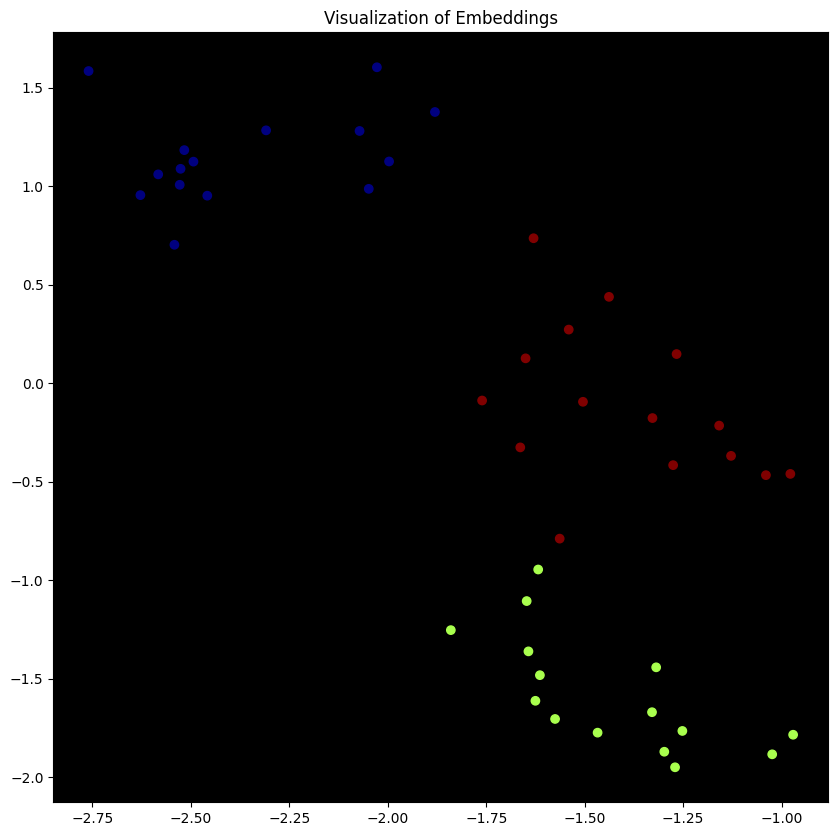

In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Assuming you have already computed `train_embs` and `train_labels`

# Step 1: Apply PCA for dimensionality reduction (optional but recommended)
# Reshape train_embs to 2D
train_embs_2d = train_embs.view(train_embs.shape[0], -1).cpu().numpy()
pca = PCA(n_components=3)  # You can choose the number of components you want
train_embs_pca = pca.fit_transform(train_embs_2d)

# Step 2: Apply t-SNE for further dimensionality reduction and visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)  # Adjust parameters as needed
train_embs_tsne = tsne.fit_transform(train_embs_pca)

# Step 3: Convert labels to numeric format using LabelEncoder
label_encoder = LabelEncoder()
train_labels_numeric = label_encoder.fit_transform(train_labels)

# Step 4: Create a dark background scatter plot
plt.figure(figsize=(10, 10))
plt.gca().set_facecolor('black')
plt.scatter(train_embs_tsne[:, 0], train_embs_tsne[:, 1], c=train_labels_numeric, cmap=plt.cm.get_cmap("jet", 10))  # Adjust colormap as needed
plt.title("Visualization of Embeddings")
plt.show()

In [13]:
model.to(device)

TripletNet(
  (enet): TEmbeddingNet(
    (modelt): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

In [14]:
model.to(torch.device("cpu"))

TripletNet(
  (enet): TEmbeddingNet(
    (modelt): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

In [20]:
import torch
from torchvision import transforms
from PIL import Image
import faiss


def get_image_embedding(image_path, model, transform):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    if transform:
        image = transform(image)

    # Add batch dimension
    image = image.unsqueeze(0)

    # Assuming the model accepts input in the form of torch.Tensor
    # Assuming the model returns embeddings
    with torch.no_grad():
        embedding = model(image)

    return embedding.to(device)

# Example usage
image_path = "/kaggle/input/tablets-dataset/Dataset/Tablet3/IMG_5611.jpg"
embedding = get_image_embedding(image_path, tmodel, transform)

def find_nearest_neighbor(embedding, index):
    _, nearest_index = index.search(embedding.reshape(1, -1), 1)
    return train_labels[nearest_index[0][0]][0]

Hello


In [18]:
import pickle
with open('train_data.pickle', 'wb') as f:
    pickle.dump((index, train_labels), f)


In [21]:
import pickle

with open('train_data.pickle', 'rb') as f:
    index, train_labels = pickle.load(f)

In [22]:
nearest_label = find_nearest_neighbor(embedding.cpu().numpy(),index)
print("Corresponding Label:", nearest_label)

Corresponding Label: Tablet3
